# Learning the update operator for the advection diffusion equation

We numerical integrate $\partial_t u + c \cdot \nabla u = d \nabla^2 u$ using a few different initial conditions. From these solutions we recover the implicit Euler update for the PDE, $(I - \Delta t \mathcal{L}) u^{n+1} = u^{n}$, where $\mathcal{L}$ is parameterized with GMLS-Nets.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import itertools
import gmlsnets_tensorflow as gnets
import sympy
import glob
import scipy

In [2]:
samps = 100

n=32
L=10

order = 2
dim = 2
fP = gnets.bases.Taylor(dim,order)
eps = L/n*(order+0.5)/2

dt=1

In [3]:
# Creates point cloud on a quarter circle for discretization. Identifies a one layer thick set of points along 
# the boundary on which Dirichlet conditions are enforced. 
x = np.array([p for p in 
                   np.reshape(
                            np.meshgrid(np.linspace(0,L,n),np.linspace(0,L,n),indexing='ij'),
                       (2,n**2)).T
               if sum(p**2)<L**2])
isborder = lambda p: sum(p**2)>.9*L**2 or p[1]<.025*L or p[0]<.025*L

# boundary points
xb = np.array([p for p in x if isborder(p)])

# interior points
xi = np.array([p for p in x if not isborder(p)])

# all points
xa = np.vstack([xb,xi])

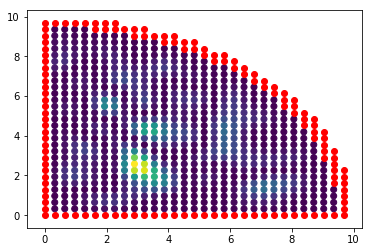

In [4]:
# Creates a function, `gen_u`, that generates smooth random functions that decay to zero at the boundaries

def K(x):
    return np.exp(-np.sum((x[:,:,0] - x[:,:,1])**2,-1))

cartp = lambda x1,x2: np.reshape(np.array(list(
                                    itertools.product(x1.tolist(),x2.tolist()))),
                            (len(x1),len(x2),2,dim))
kbb = K(cartp(xb,xb))
kib = K(cartp(xi,xb))
kii = K(cartp(xi,xi))

mu = np.einsum('ij,jk,k',kib,np.linalg.inv(kbb),np.zeros(len(xb)))
cov = kii-np.einsum('ij,jk,kl',kib,np.linalg.inv(kbb),kib.T)

ksq = np.linalg.cholesky(cov+1e-6*np.eye(len(xi)))
gen_u = lambda: (mu + np.dot(ksq,np.random.normal(0,1,len(xi))))**2

# plots a sample from `gen_u`. The boundary points are shown in red
plt.scatter(xi[:,0],xi[:,1],c=gen_u())
plt.scatter(xb[:,0],xb[:,1],c='r')

In [5]:
# GMLS layer
interp = gnets.MFLayer(xa,xi,fP,gnets.weightfuncs.fourth,eps)



# creates true inverse Euler update operator with GMLS discretization
def makeD(ds):
    D = np.zeros(fP.len)
    D[sorted(fP.indc).index(ds)] = 1./eps**len(ds)
    return tf.constant(D)

Dx = makeD((0,))
Dy = makeD((1,))
Dx2 = makeD((0,0))
Dy2 = makeD((1,1))

def ATrue(Unew):    
    Cnew = interp(tf.pad(Unew,[[0,0],[len(xb),0]]))
    Lop = dt * (-.1*(Dx2+Dy2)+(Dx+Dy))
    Uold = Unew + tf.reduce_sum(Cnew * Lop,-1)
    return Uold



# creates parameterized inverse Euler update operator
Lop_reg = tf.Variable(np.random.normal(0,1,fP.len))
def AReg(Unew):    
    Cnew = interp(tf.pad(Unew,[[0,0],[len(xb),0]]))
    Uold = Unew + tf.reduce_sum(Cnew * Lop_reg,-1)
    return Uold

In [6]:
# sets up training function
compute_loss = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(learning_rate=.1)

def train(Uold,Unew):
    with tf.GradientTape() as tape:
        loss = tf.reduce_mean(compute_loss(Uold, AReg(Unew)))

    grads = tape.gradient(loss, [Lop_reg])
    optimizer.apply_gradients(zip(grads, [Lop_reg]))

    return loss.numpy()

In [7]:
Ainv_true = scipy.sparse.linalg.LinearOperator((len(xi),len(xi)),
                                            matvec = lambda u: ATrue([u]).numpy()[0])
Ainv_reg  = scipy.sparse.linalg.LinearOperator((len(xi),len(xi)),
                                            matvec = lambda u: AReg([u]).numpy()[0])

# Creates true update operator
updtrue = lambda u: scipy.sparse.linalg.bicgstab(Ainv_true,u,tol=1e-8)[0]

# Creates parameterized update operator
updreg = lambda u: scipy.sparse.linalg.bicgstab(Ainv_reg,u,tol=1e-8)[0]

In [8]:
#Random intitial conditions
uoldtrain = np.array([gen_u() for i in range(samps)])

#One update applied to the set of ICs above with true update operator
unewtrain = np.array(list(map(updtrue,uoldtrain)))

In [9]:
# trains the regressed operator
bs = samps
for _ in range(1000):
    for i in range(0,samps//bs):
        c = train(uoldtrain[bs*i:bs*(i+1)],unewtrain[bs*i:bs*(i+1)])
        print(c)

1.7520349538454416
1.582648343135294
1.4270748188277915
1.2854715369416863
1.1578582797730526
1.0440796319094034
0.9437642711125267
0.8562867794273414
0.7807407523994686
0.7159346942406686
0.6604221437840923
0.6125729467016039
0.5706833485998402
0.5331105151370239
0.49840643466089884
0.4654227235392146
0.43336525428219175
0.4017930132764321
0.3705712027333851
0.3397973241207829
0.3097192346664124
0.28065896322888917
0.252949543284965
0.22688706366691463
0.2026974701073337
0.18051695462213296
0.16038502643582203
0.1422495277457484
0.12598228483406695
0.11140275895229015
0.09830561966011128
0.08648748260160687
0.07576860467245583
0.06600685761999667
0.05710312881111073
0.048998857911319985
0.04166748747010999
0.03510219291961647
0.029302428409694513
0.0242616343180757
0.019957961978579967
0.01634917208139469
0.013372072281551763
0.010946099540372399
0.008980030710586022
0.007380398411266427
0.006060040496595625
0.004945325691382511
0.0039809432383285485
0.003131652775365794
0.00238096575

9.746236688984513e-17
9.57862656353974e-17
9.368833449360697e-17
9.147070414757406e-17
8.938704515358915e-17
8.755496737804753e-17
8.594501795429174e-17
8.444191787181004e-17
8.293780685571937e-17
8.140696960039909e-17
7.99267798758019e-17
7.864011272635704e-17
7.768439208316432e-17
7.712651231369727e-17
7.693502760785735e-17
7.699832764817236e-17
7.717436262559304e-17
7.734526284261636e-17
7.745218660542273e-17
7.749845460080861e-17
7.752538374621752e-17
7.757720717737845e-17
7.767362603007119e-17
7.780118945725006e-17
7.792341130622772e-17
7.800078976339492e-17
7.800917377810118e-17
7.794802715559413e-17
7.783655073102122e-17
7.770189503401623e-17
7.756675552398285e-17
7.744238530029608e-17
7.732898043411992e-17
7.722129058141837e-17
7.711527489840387e-17
7.70120818302986e-17
7.691779829836772e-17
7.683995621945112e-17
7.678337769152825e-17
7.674784846950752e-17
7.672863734791696e-17
7.671913532748577e-17
7.671390094868824e-17
7.671049946211224e-17
7.670941483646682e-17
7.67124223091

7.668108351397481e-17
7.668108351328e-17
7.668108351218286e-17
7.66810835146185e-17
7.668108351528155e-17
7.668108351481899e-17
7.668108351462467e-17
7.668108351498884e-17
7.668108351514706e-17
7.668108351460565e-17
7.668108351274252e-17
7.668108351226074e-17
7.668108351276818e-17
7.668108351214481e-17
7.668108351296972e-17
7.668108351476474e-17
7.668108351502158e-17
7.668108351527467e-17
7.668108351499418e-17
7.668108351512726e-17
7.668108351483861e-17
7.668108351394342e-17
7.668108351305475e-17
7.66810835128431e-17
7.66810835128431e-17
7.668108351305475e-17
7.668108351374875e-17
7.668108351478423e-17
7.668108351503961e-17
7.668108351513033e-17
7.668108351502366e-17
7.668108351485848e-17
7.66810835146012e-17
7.668108351345598e-17
7.668108351339748e-17
7.668108351344081e-17
7.668108351374282e-17
7.668108351459301e-17
7.668108351485588e-17
7.668108351483859e-17
7.668108351484921e-17
7.668108351483859e-17
7.668108351485846e-17
7.668108351475797e-17
7.66810835141626e-17
7.668108351394736e

Text(0, 0.5, 'reg')

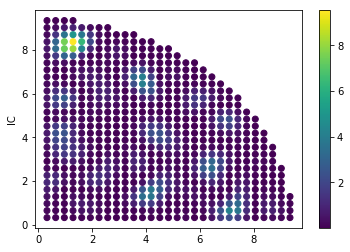

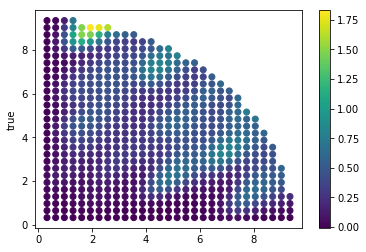

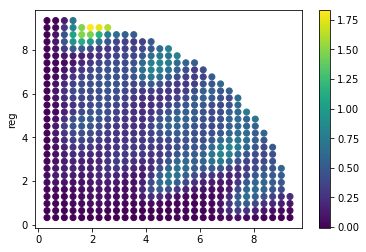

In [10]:
# random IC
utest = gen_u()

# applies two true updates on IC
utesttrue = updtrue(updtrue(utest))

# applies two regressed updates on IC
utestreg = updreg(updreg(utest))

#plots IC, the true update on IC, and the regressed update on IC
plt.figure()
plt.scatter(xi[:,0],xi[:,1],c=utest)
plt.colorbar()
plt.ylabel('IC')

plt.figure()
plt.scatter(xi[:,0],xi[:,1],c=utesttrue)
plt.colorbar()
plt.ylabel('true')

plt.figure()
plt.scatter(xi[:,0],xi[:,1],c=utestreg)
plt.colorbar()
plt.ylabel('reg')